In [31]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

import warnings
warnings.filterwarnings('ignore')

In [32]:
train = "./dataset/train"
labels = pd.read_csv('./dataset/train.csv')

In [33]:
print(labels['label'].value_counts())

Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: label, dtype: int64


In [34]:
validation_split = 0.8
indexes = np.random.permutation(range(len(labels))) < validation_split*len(labels)

train_labels = labels[indexes]
validation_labels = labels[~indexes]
print(len(train_labels))
print(len(validation_labels))

6582
1645


In [35]:
validation_labels

,image_ID,label
4,cfd2c28c74.jpg,Cricket
8,b956f3bba8.jpg,Badminton
9,d02a1baab5.jpg,Badminton
12,3dfbc69050.jpg,Badminton
13,f99738d57b.jpg,Badminton
...,...,...
8213,fb1afffcf1.jpg,Wrestling
8215,5e04258d16.jpg,Cricket
8219,a7080caa11.jpg,Karate
8221,ea6b657b01.jpg,Karate


In [36]:
class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
            print("\n Nilai akurasi pada data training dan data validation lebih dari 85%") 
            self.model.stop_training = True 
 
callbacks = Callback()

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_labels, 
                                                    directory=train,
                                                    x_col='image_ID',
                                                    y_col='label',
                                                    target_size=(150,150),
                                                    batch_size=64,
                                                    class_mode="categorical", 
                                                    validation_split = 0.2)

Found 6582 validated image filenames belonging to 7 classes.


In [38]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_labels, 
                                                              directory=train,
                                                              x_col='image_ID',
                                                              y_col='label',
                                                              target_size=(150,150),
                                                              batch_size=64,
                                                              class_mode="categorical",
                                                              validation_split = 0.2)

Found 1645 validated image filenames belonging to 7 classes.


In [39]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))
 
for layer in pre_trained_model.layers[:-10]:
    layer.trainable = False
 
last_output = pre_trained_model.output

x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 19, 19, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
          

                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malizatio

 block_10_project (Conv2D)      (None, 10, 10, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_

 block_14_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_

In [40]:
optimizer = tf.optimizers.Adam(lr=1e-04)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/20
103/103 - 414s - loss: 1.1689 - accuracy: 0.5772 - val_loss: 1.2478 - val_accuracy: 0.6486 - 414s/epoch - 4s/step
Epoch 2/20
103/103 - 331s - loss: 0.7605 - accuracy: 0.7309 - val_loss: 0.8640 - val_accuracy: 0.7672 - 331s/epoch - 3s/step
Epoch 3/20
103/103 - 402s - loss: 0.6280 - accuracy: 0.7820 - val_loss: 0.9411 - val_accuracy: 0.7550 - 402s/epoch - 4s/step
Epoch 4/20
103/103 - 411s - loss: 0.5616 - accuracy: 0.8063 - val_loss: 0.8534 - val_accuracy: 0.7745 - 411s/epoch - 4s/step
Epoch 5/20
103/103 - 411s - loss: 0.5110 - accuracy: 0.8215 - val_loss: 0.9360 - val_accuracy: 0.7787 - 411s/epoch - 4s/step
Epoch 6/20
103/103 - 409s - loss: 0.4534 - accuracy: 0.8388 - val_loss: 0.9728 - val_accuracy: 0.7903 - 409s/epoch - 4s/step
Epoch 7/20
103/103 - 406s - loss: 0.4204 - accuracy: 0.8505 - val_loss: 0.6067 - val_accuracy: 0.8474 - 406s/epoch - 4s/step
Epoch 8/20
103/103 - 369s - loss: 0.3831 - accuracy: 0.8678 - val_loss: 0.8195 - val_accuracy: 0.8195 - 369s/epoch - 4s/step


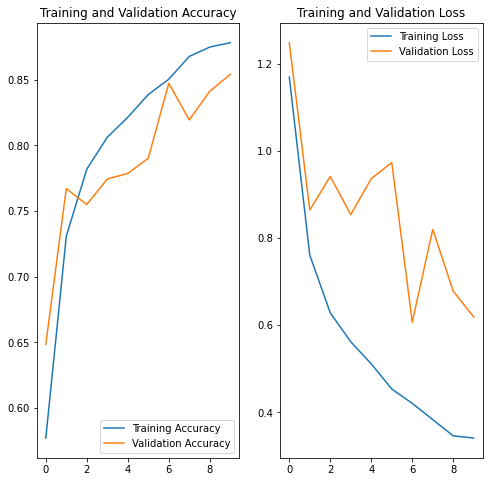

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('sports.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


25314804